# 📘 Customer Churn — Modeling & Evaluation

## 🎯 Goals
- Train and compare **Logistic Regression**, **Random Forest**, and **LightGBM**.
- Handle **class imbalance** (SMOTE) and ensure leakage-free preprocessing.
- Evaluate with **ROC AUC**, **PR AUC (Average Precision)**, **F1**, **Precision/Recall**.
- Explore **decision thresholds** to match business goals.
- **Auto-select** and save the best model.

## 🔁 Quick EDA Recap (from previous notebook)
- Churn rate ≈ **20%** → imbalanced dataset.
- Churners tend to have **higher balance** and **fewer products**.
- No single strong predictor → **non-linear/ensemble** models may perform well.

---


In [23]:
# ================================
# 0) Imports & Setup
# ================================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    roc_auc_score, roc_curve, average_precision_score, precision_recall_curve,
    precision_score, recall_score, f1_score, make_scorer
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# LightGBM
try:
    from lightgbm import LGBMClassifier
except ImportError as e:
    raise SystemExit("LightGBM not installed. Run: pip install lightgbm") from e

# Imbalanced-learn
try:
    from imblearn.over_sampling import SMOTE
    from imblearn.pipeline import Pipeline as ImbPipeline
except ImportError as e:
    raise SystemExit("imbalanced-learn not installed. Run: pip install imbalanced-learn") from e

# Reuse your FeatureEngineer from the preprocessing notebook
from sklearn.base import BaseEstimator, TransformerMixin

# Load processed dataset
df = pd.read_csv("../data/preprocessed_churn.csv")

# Split features & target
X = df.drop(columns=["Exited"])
y = df["Exited"].astype(int)

# Train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [24]:
def make_pipeline(model, use_smote=True):
    steps = []
    
    # Only add SMOTE if required
    if use_smote:
        steps.append(("smote", SMOTE(random_state=42)))
    
    steps.append(("clf", model))
    
    return ImbPipeline(steps=steps)

In [25]:
# ================================
# 2) Define Models
# ================================
models = {
    "Logistic Regression": LogisticRegression(max_iter=2000, class_weight=None, n_jobs=None if hasattr(LogisticRegression(), "n_jobs") else None),
    "Random Forest": RandomForestClassifier(
        n_estimators=300, max_depth=None, min_samples_split=2, random_state=42, n_jobs=-1
    ),
    "LightGBM": LGBMClassifier(
        n_estimators=600, learning_rate=0.03, subsample=0.8, colsample_bytree=0.8,
        random_state=42, n_jobs=-1
    )
}


In [26]:
# ================================
# 3) Cross-Validation (5-fold)
#    We use PR AUC (average precision), ROC AUC, F1
# ================================
scoring = {
    "roc_auc": "roc_auc",
    "pr_auc": make_scorer(average_precision_score, needs_proba=True),
    "f1": "f1",
    "precision": "precision",
    "recall": "recall",
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_table = []

for name, clf in models.items():
    pipe = make_pipeline(clf)
    scores = cross_validate(pipe, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)
    row = {
        "model": name,
        "cv_roc_auc": scores["test_roc_auc"].mean(),
        "cv_pr_auc": scores["test_pr_auc"].mean(),
        "cv_f1": scores["test_f1"].mean(),
        "cv_precision": scores["test_precision"].mean(),
        "cv_recall": scores["test_recall"].mean(),
    }
    cv_table.append(row)

cv_df = pd.DataFrame(cv_table).sort_values("cv_pr_auc", ascending=False)
print("📊 5-Fold CV (train split only):")
display(cv_df)


g:\prog\python\Lib\site-packages\sklearn\metrics\_scorer.py:548: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


📊 5-Fold CV (train split only):


,model,cv_roc_auc,cv_pr_auc,cv_f1,cv_precision,cv_recall
2,LightGBM,0.843362,0.653293,0.581268,0.655075,0.522699
1,Random Forest,0.836346,0.604445,0.575362,0.604362,0.549693
0,Logistic Regression,0.752492,0.399441,0.487270,0.380206,0.678528



==== Logistic Regression: Test Metrics @ threshold=0.50 ====
ROC AUC: 0.745 | PR AUC: 0.388 | F1: 0.483 | Precision: 0.371 | Recall: 0.691

Classification Report:
              precision    recall  f1-score   support

           0      0.898     0.700     0.787      1593
           1      0.371     0.691     0.483       408

    accuracy                          0.698      2001
   macro avg      0.635     0.696     0.635      2001
weighted avg      0.791     0.698     0.725      2001



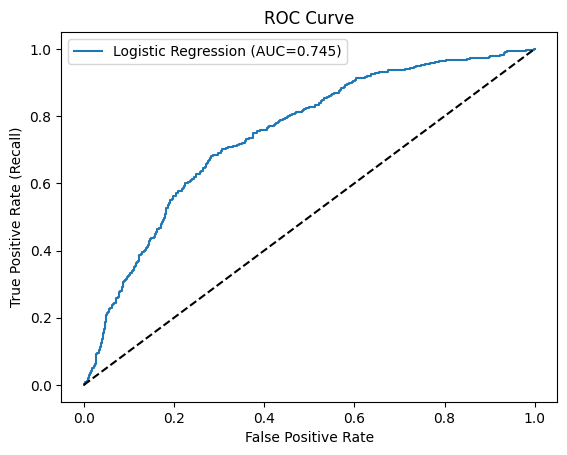

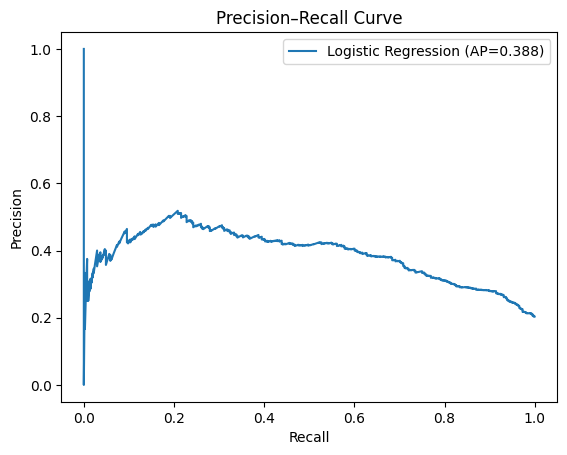

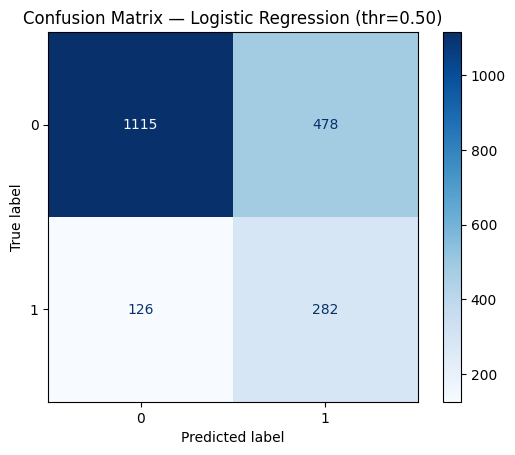


==== Random Forest: Test Metrics @ threshold=0.50 ====
ROC AUC: 0.837 | PR AUC: 0.607 | F1: 0.564 | Precision: 0.582 | Recall: 0.547

Classification Report:
              precision    recall  f1-score   support

           0      0.886     0.900     0.893      1593
           1      0.582     0.547     0.564       408

    accuracy                          0.828      2001
   macro avg      0.734     0.723     0.728      2001
weighted avg      0.824     0.828     0.826      2001



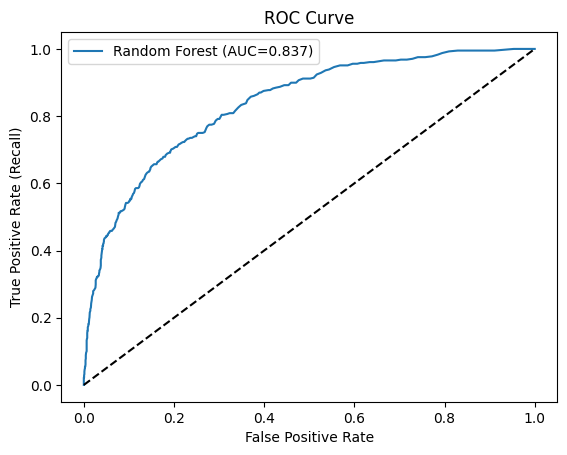

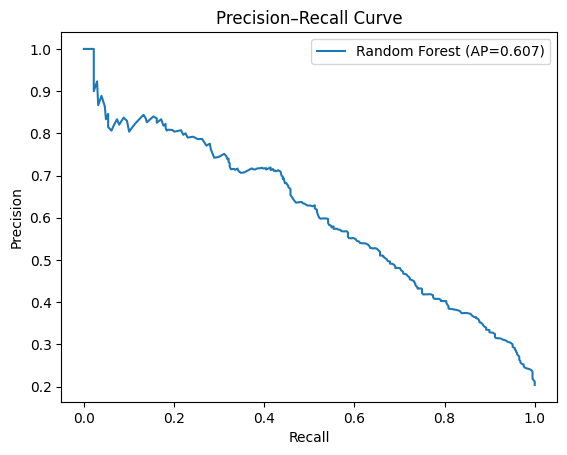

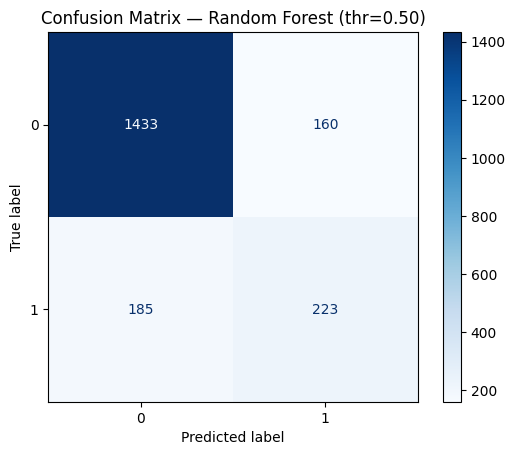

[LightGBM] [Info] Number of positive: 6371, number of negative: 6371
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000459 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2304
[LightGBM] [Info] Number of data points in the train set: 12742, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

==== LightGBM: Test Metrics @ threshold=0.50 ====
ROC AUC: 0.848 | PR AUC: 0.665 | F1: 0.589 | Precision: 0.646 | Recall: 0.542

Classification Report:
              precision    recall  f1-score   support

           0      0.887     0.924     0.905      1593
           1      0.646     0.542     0.589       408

    accuracy                          0.846      2001
   macro avg      0.767     0.733     0.747      2001
weighted avg      0.838     0.846     0.841      2001



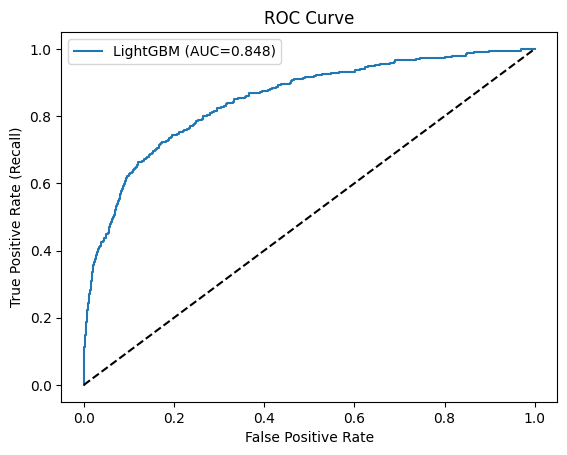

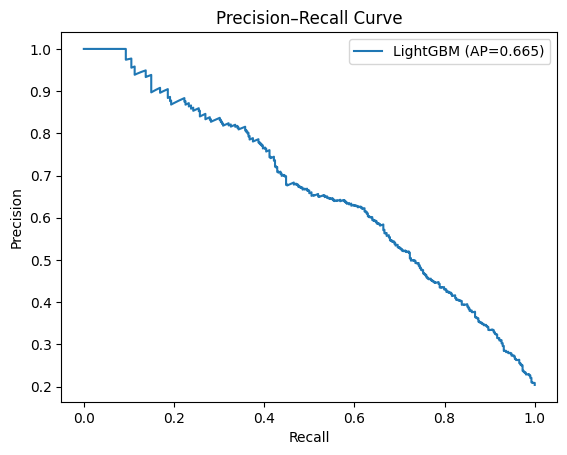

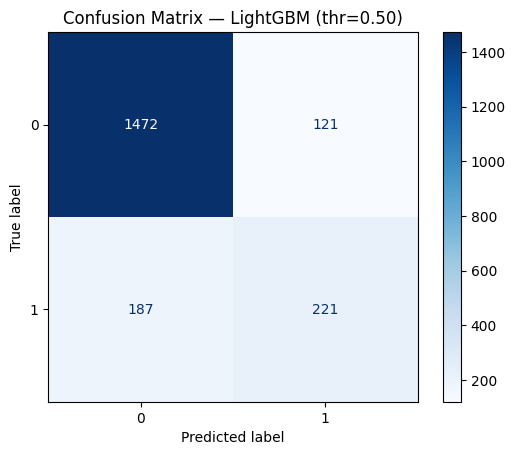


📌 Test-set metrics (sorted by PR AUC):


,roc_auc,pr_auc,f1,precision,recall
LightGBM,0.848430,0.665104,0.589333,0.646199,0.541667
Random Forest,0.836783,0.607134,0.563843,0.582245,0.546569
Logistic Regression,0.745207,0.388404,0.482877,0.371053,0.691176


In [27]:
# ================================
# 4) Train on Train, Evaluate on Test
#    (Default 0.5 threshold + curves)
# ================================
def evaluate_on_test(name, pipeline, X_test, y_test, plot=True):
    y_pred = pipeline.predict(X_test)
    # Probabilities or decision function for metrics
    if hasattr(pipeline.named_steps["clf"], "predict_proba"):
        y_proba = pipeline.predict_proba(X_test)[:, 1]
    else:
        # Some models might not have proba; decision_function fallback
        y_proba = pipeline.decision_function(X_test)

    roc = roc_auc_score(y_test, y_proba)
    pr = average_precision_score(y_test, y_proba)
    f1 = f1_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)

    print(f"\n==== {name}: Test Metrics @ threshold=0.50 ====")
    print(f"ROC AUC: {roc:.3f} | PR AUC: {pr:.3f} | F1: {f1:.3f} | Precision: {prec:.3f} | Recall: {rec:.3f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, digits=3))

    if plot:
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.figure()
        plt.plot(fpr, tpr, label=f"{name} (AUC={roc:.3f})")
        plt.plot([0,1],[0,1],'k--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate (Recall)")
        plt.title("ROC Curve")
        plt.legend()
        plt.show()

        precs, recs, _ = precision_recall_curve(y_test, y_proba)
        plt.figure()
        plt.plot(recs, precs, label=f"{name} (AP={pr:.3f})")
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title("Precision–Recall Curve")
        plt.legend()
        plt.show()

        cm = confusion_matrix(y_test, y_pred)
        ConfusionMatrixDisplay(cm).plot(cmap="Blues")
        plt.title(f"Confusion Matrix — {name} (thr=0.50)")
        plt.show()

    return {"roc_auc": roc, "pr_auc": pr, "f1": f1, "precision": prec, "recall": rec}

# Fit each model on train and evaluate on test
test_metrics = {}
trained_pipes = {}

for name, clf in models.items():
    pipe = make_pipeline(clf)
    pipe.fit(X_train, y_train)
    trained_pipes[name] = pipe
    test_metrics[name] = evaluate_on_test(name, pipe, X_test, y_test, plot=True)

test_df = pd.DataFrame(test_metrics).T.sort_values("pr_auc", ascending=False)
print("\n📌 Test-set metrics (sorted by PR AUC):")
display(test_df)



🎯 Threshold tuning for **LightGBM** (beta=1.0):
{'best_threshold': 0.4155761060614247, 'best_precision': 0.6225490196078431, 'best_recall': 0.6225490196078431, 'best_fbeta': 0.6225490196073431}

Classification Report @ tuned threshold:
              precision    recall  f1-score   support

           0      0.903     0.903     0.903      1593
           1      0.621     0.623     0.622       408

    accuracy                          0.846      2001
   macro avg      0.762     0.763     0.762      2001
weighted avg      0.846     0.846     0.846      2001



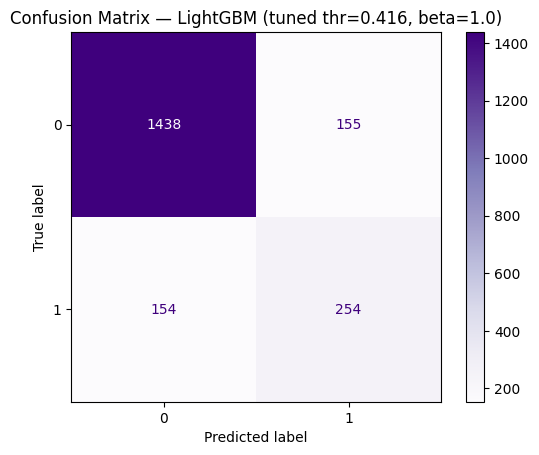

In [28]:
# ================================
# 5) Threshold Tuning (optimize F1 or Fβ)
#    Choose a beta (>1 emphasize recall, <1 emphasize precision)
# ================================
def find_best_threshold(y_true, y_scores, beta=1.0):
    prec, rec, thr = precision_recall_curve(y_true, y_scores)
    # Avoid division by zero
    fbeta = (1 + beta**2) * (prec * rec) / (beta**2 * prec + rec + 1e-12)
    idx = np.nanargmax(fbeta)
    return {
        "best_threshold": thr[idx-1] if idx > 0 and idx-1 < len(thr) else 0.5,
        "best_precision": float(prec[idx]),
        "best_recall": float(rec[idx]),
        "best_fbeta": float(fbeta[idx]),
    }

# Choose which model to tune (best by PR AUC on test)
best_name = test_df.index[0]
best_pipe = trained_pipes[best_name]

# Scores for tuning
if hasattr(best_pipe.named_steps["clf"], "predict_proba"):
    y_scores = best_pipe.predict_proba(X_test)[:, 1]
else:
    y_scores = best_pipe.decision_function(X_test)

# Set business preference here:
BETA = 1.0  # >1 for recall focus, <1 for precision focus
tune = find_best_threshold(y_test, y_scores, beta=BETA)
print(f"\n🎯 Threshold tuning for **{best_name}** (beta={BETA}):")
print(tune)

# Evaluate at tuned threshold
thr = tune["best_threshold"]
y_pred_tuned = (y_scores >= thr).astype(int)

print("\nClassification Report @ tuned threshold:")
print(classification_report(y_test, y_pred_tuned, digits=3))

cm = confusion_matrix(y_test, y_pred_tuned)
ConfusionMatrixDisplay(cm).plot(cmap="Purples")
plt.title(f"Confusion Matrix — {best_name} (tuned thr={thr:.3f}, beta={BETA})")
plt.show()


In [29]:
# ================================
# 6) Auto-select & Save Best Model
#    (by PR AUC on test set — recommended for imbalance)
# ================================
best_model_name = test_df.index[0]
best_model_pipe = trained_pipes[best_model_name]